# Lab 3 Hiroshi-Ishikawa 

In [1]:
import copy
import numpy as np

from numpy.random import shuffle
from numba import njit
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm

import funcs as f
import utils as utl

---

## Input

Input size:  (3, 3)
dtype: uint8 | max: 188 | min: 51


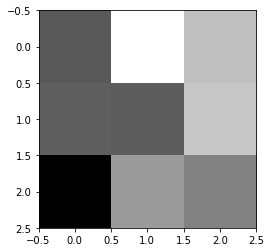

In [2]:
C = np.array([ 0, 128, 255])
binary_penalty = 70
shape = (3,3)
img = utl.import_img("input.png", bw=True, newshape=shape)

In [3]:
@njit
def init_g(img, C, betta):
    
    height, width = img.shape[:2]
    img = img.flatten()
    csize = C.size
    g = np.zeros((height*width*csize + 2, height*width*csize + 2), dtype = np.float32)

    for i in range(width):
        if i==0 or i ==width-1:
            for j in range(height):
                if j==0 or j == height-1:
                    # 4 corner point
                    for k in range(csize):
                        index = (i * height + j) * csize + k
                        # horizontal
                        h_index = ((int(i == 0) * (i + 1) + int(i == width - 1) * (i - 1)) * height + j) * csize + k
                        g[index, h_index] = betta
                        # vertical
                        v_index = (i * height + int(j == 0) * (j + 1) + int(j == height - 1) * (j - 1)) * csize + k
                        g[index, v_index] = betta
                        if(k == csize-1):
                            up_index = -1
                            g[index, up_index] = np.abs(C[k] - img[j + i*width])
                        else:
                            up_index = index+1
                            g[index, up_index] = np.abs(C[k] - img[j + i*width])
                        if k!=0:
                            down_index = index-1
                            g[index,down_index] = np.inf
                else:
                    # left and right edges without 4 corners
                    for k in range(csize):
                        index = (i * height + j) * csize + k
                        # horizontal
                        h_index = ((int(i == 0) * (i + 1) + int(i == width - 1) * (i - 1)) * height + j) * csize + k
                        g[index, h_index] = betta
                        # vertical up
                        v_up_index = (i * height + j - 1) * csize + k
                        g[index, v_up_index] = betta
                        # vertical down
                        v_down_index = (i * height + j + 1) * csize + k
                        g[index, v_down_index] = betta
                        if(k == csize-1):
                            up_index = -1
                            g[index, up_index] = np.abs(C[k] - img[j + i*width])
                        else:
                            up_index = index+1
                            g[index, up_index] = np.abs(C[k] - img[j + i*width])
                        if k!=0:
                            down_index = index-1
                            g[index,down_index] = np.inf
        else:
            for j in range(height):
                if j==0 or j == height-1:
                    for k in range(csize):
                        index = (i * height + j) * csize + k
                        # horizontal left
                        h_left_index = ((i - 1) * height + j) * csize + k
                        g[index, h_left_index] = betta
                        # horizontal right
                        h_right_index = ((i + 1) * height + j) * csize + k
                        g[index, h_right_index] = betta
                        # vertical up
                        v_up_index = (i * height + j - 1) * csize + k
                        g[index, v_up_index] = betta
                        # vertical down
                        v_down_index = (i * height + j + 1) * csize + k
                        g[index, v_down_index] = betta
                        if(k == csize-1):
                            up_index = -1
                            g[index, up_index] = np.abs(C[k] - img[j + i*width])
                        else:
                            up_index = index+1
                            g[index, up_index] = np.abs(C[k] - img[j + i*width])
                        if k!=0:
                            down_index = index-1
                            g[index,down_index] = np.inf
                else:
                    for k in range(csize):
                        index = (i * height + j) * csize + k
                        # horizontal left
                        h_left_index = ((i - 1) * height + j) * csize + k
                        g[index, h_left_index] = betta
                        # horizontal right
                        h_right_index = ((i + 1) * height + j) * csize + k
                        g[index, h_right_index] = betta
                        # vertical up
                        v_up_index = (i * height + j - 1) * csize + k
                        g[index, v_up_index] = betta
                        # vertical down
                        v_down_index = (i * height + j + 1) * csize + k
                        g[index, v_down_index] = betta
                        if(k == csize-1):
                            up_index = -1
                            g[index, up_index] = np.abs(C[k] - img[j + i*width])
                        else:
                            up_index = index+1
                            g[index, up_index] = np.abs(C[k] - img[j + i*width])
                        if k!=0:
                            down_index = index-1
                            g[index,down_index] = np.inf
    #  source
    for i in range(width):
        for j in range(height):
            index = (i * height + j)*csize
            g[-2, index] = np.inf
    return g

#print(f"k: {k} | i,j: {i,j} | index: {index} | pixel_ind: {j+i*w}")

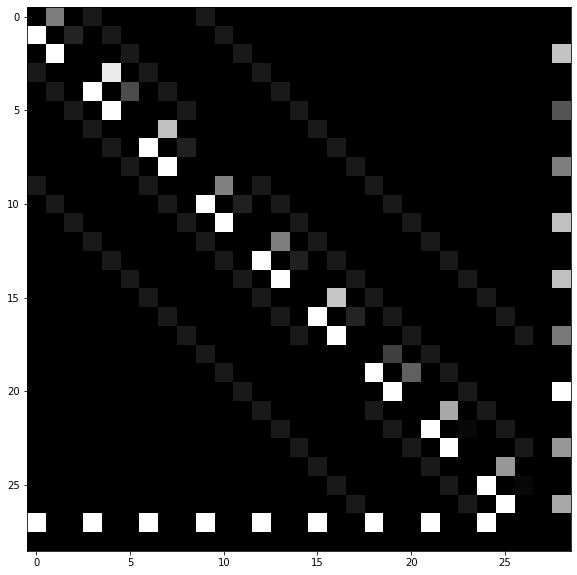

In [4]:
g = init_g(img, C, betta=20)
plt.subplots(figsize=(10, 10))
plt.imshow(g, cmap='gray')

---

In [5]:
#@njit
def iteration(G, F):
    
    Prev = np.full(Vsize, -1) # Prev node
    Q = [-2] # Queue
    cursor = 0 # instead of popping elements of of the Q

    while cursor < Vsize:

        v_curr = Q[cursor]
        for v_ind, capacity in enumerate( G[v_curr] ):
            if F[v_curr, v_ind] < capacity and Prev[v_ind] == -1 and v_ind != v_curr:
                Q.append(v_ind)
                Prev[v_ind] = v_curr

        cursor += 1
        if cursor >= len(Q) : break

    # path reconstruction
    v_curr = Vsize - 1
    path = [v_curr]
    while True:
        v_prev = Prev[v_curr]
        v_curr = v_prev
        if v_curr == -1 : break
        path.append(v_curr)

    path = path[::-1]
    
    
    
    # path bottleneck
    bottleneck = np.inf # float('inf') doesn't work with numba
    for i in range(len(path) - 1):
        v_curr = path[i]
        v_next = path[i+1]

        local_w = G[v_curr, v_next] - F_[v_curr, v_next]
        if local_w < bottleneck: 
            bottleneck = local_w
    if bottleneck == np.inf : return F, True
    
    print("path: ", path, " | bottleneck: ", bottleneck)
    
    # path flow update
    for i in range(len(path) - 1):
        v_curr = path[i]
        v_next = path[i+1]

        F[v_curr, v_next] += bottleneck
        
    
    #print('')
    #print('----- New iteration -----')
    #show_path(path, V)
    #print('Bottleneck is: ', bottleneck)
    
    return F, False

In [6]:
h, w = img.shape[:2]
csize = C.size
Vsize = h*w*csize + 2

F_ = np.zeros((Vsize, Vsize)) # Current flow

In [7]:
while True:
        F_, end = iteration(g, F_)
        if end : break
print('MaxFlow is: ', sum(F_[:, -1]))

path:  [-2, 0, 1, 2, 28]  | bottleneck:  29.0
path:  [-2, 3, 4, 5, 28]  | bottleneck:  60.0
path:  [-2, 6, 7, 8, 28]  | bottleneck:  26.0
path:  [-2, 9, 10, 11, 28]  | bottleneck:  26.0
path:  [-2, 12, 13, 14, 28]  | bottleneck:  27.0
path:  [-2, 15, 16, 17, 28]  | bottleneck:  30.0
path:  [-2, 18, 19, 20, 28]  | bottleneck:  51.0
path:  [-2, 21, 22, 23, 28]  | bottleneck:  6.0
path:  [-2, 24, 25, 26, 28]  | bottleneck:  7.0
path:  [-2, 9, 10, 19, 20, 28]  | bottleneck:  20.0
path:  [-2, 15, 16, 19, 20, 28]  | bottleneck:  6.0
MaxFlow is:  288.0
